# Імпортування модулів, класів та функцій

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV, train_test_split

# Заповнення ДатаФрейму

In [2]:
def rename_column(dataframe: pd.DataFrame, old_column_name: str, new_column_name: str) -> None:
    dataframe = dataframe.rename(columns = {old_column_name: new_column_name}, inplace = True)


def drop_column(dataframe: pd.DataFrame, column_name: str) -> None:
    dataframe = dataframe.drop(columns = [column_name], inplace = True)


def replace_column_str(dataframe: pd.DataFrame, column_name: str, old_value: str, new_value: str) -> None:
    dataframe[column_name] = dataframe[column_name].replace(old_value, new_value, regex = True)


def convert_str_datetime(dataframe: pd.DataFrame, column_name: str) -> None:
    dataframe[column_name] = pd.to_datetime(dataframe[column_name])


sneakers_data = pd.read_csv("sneakers2023.csv", sep = ',', encoding = "utf-8")

drop_column(sneakers_data, "Unnamed: 0")

rename_column(sneakers_data, "pricePremium", "Price Premium")
rename_column(sneakers_data, "brand", "Brand")
rename_column(sneakers_data, "item", "Sneaker Name")
rename_column(sneakers_data, "retail", "Retail Price")
rename_column(sneakers_data, "release", "Release Date")
rename_column(sneakers_data, "lowestAsk", "Lowest Ask")
rename_column(sneakers_data, "volatility", "Volatility")
rename_column(sneakers_data, "highestBid", "Highest Bid")
rename_column(sneakers_data, "annualLow", "Annual Lowest")
rename_column(sneakers_data, "annualHigh", "Annual Highest")
rename_column(sneakers_data, "numberOfAsks", "Number Of Asks")
rename_column(sneakers_data, "numberOfBids", "Number Of Bids")
rename_column(sneakers_data, "deadstockSold", "Deadstock Sold")
rename_column(sneakers_data, "salesThisPeriod", "Sold This Year")
rename_column(sneakers_data, "changePercentage", "Change Percentage")
rename_column(sneakers_data, "averageDeadstockPrice", "Average Deadstock Price")

replace_column_str(sneakers_data, "Brand", "Asics", "ASICS")
replace_column_str(sneakers_data, "Brand", "adidas", "Adidas")
replace_column_str(sneakers_data, "Sneaker Name", "adidas", "Adidas")

convert_str_datetime(sneakers_data, "Release Date")

sneakers_data.drop_duplicates(subset = "Sneaker Name", keep = False, inplace = True)

mean_retail_price = sneakers_data.groupby("Brand")["Retail Price"].transform("mean")
sneakers_data["Retail Price"].mask(sneakers_data["Retail Price"] == 0, mean_retail_price, inplace = True)

sneakers_data.loc[(sneakers_data["Price Premium"] == np.inf), "Price Premium"] = (sneakers_data["lastSale"] - sneakers_data["Retail Price"]) / sneakers_data["Retail Price"]
drop_column(sneakers_data, "lastSale")

print(sneakers_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Sneaker Name             1338 non-null   object        
 1   Brand                    1338 non-null   object        
 2   Retail Price             1338 non-null   float64       
 3   Release Date             1263 non-null   datetime64[ns]
 4   Lowest Ask               1338 non-null   int64         
 5   Number Of Asks           1338 non-null   int64         
 6   Sold This Year           1338 non-null   int64         
 7   Highest Bid              1338 non-null   int64         
 8   Number Of Bids           1338 non-null   int64         
 9   Annual Highest           1338 non-null   int64         
 10  Annual Lowest            1338 non-null   int64         
 11  Volatility               1338 non-null   float64       
 12  Deadstock Sold           1338 non-

# Матриця кореляції

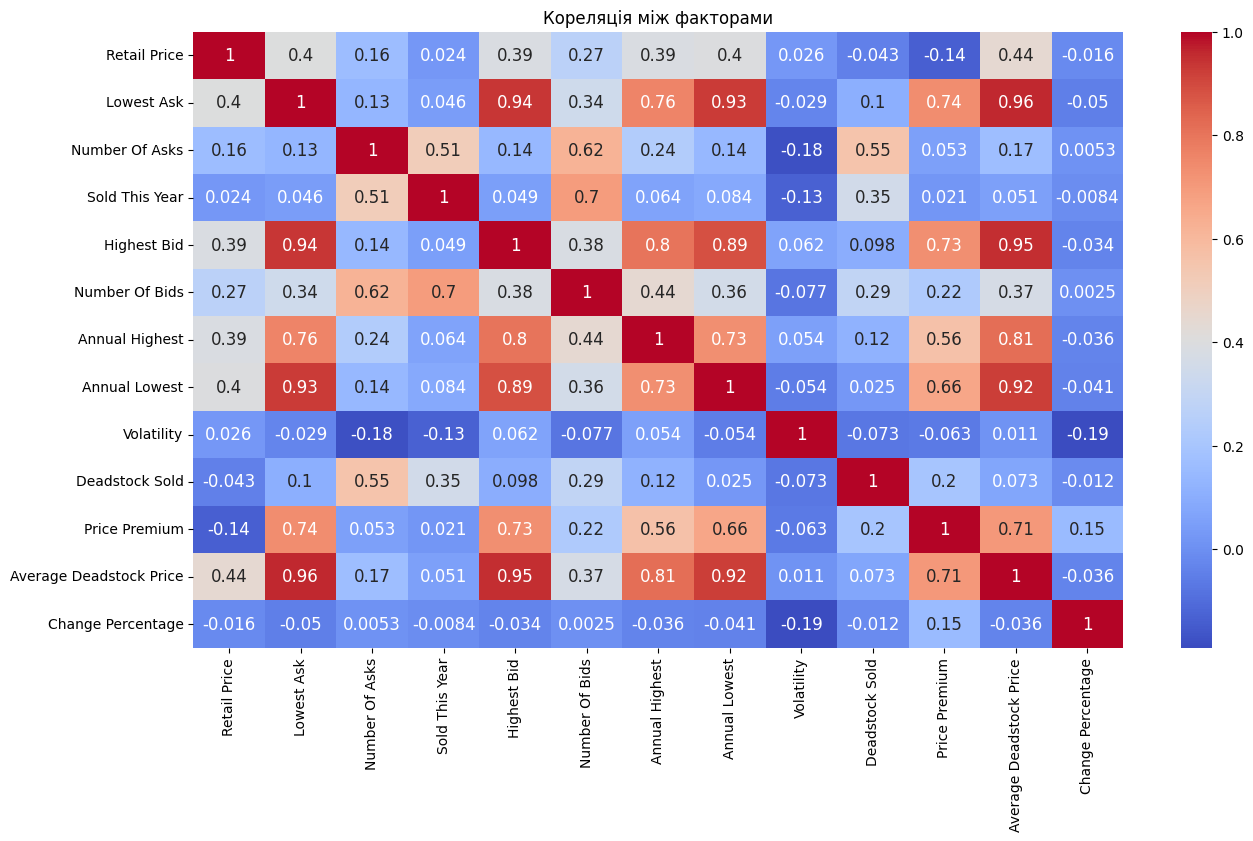

In [3]:
fig, axis = plt.subplots(figsize = (15, 8))
axis.set_title("Кореляція між факторами")
sns.heatmap(sneakers_data.corr(numeric_only = True), ax = axis, annot = True, cmap = "coolwarm", annot_kws = {"fontsize": 12})
plt.show()

# Розподіл Annual Highest

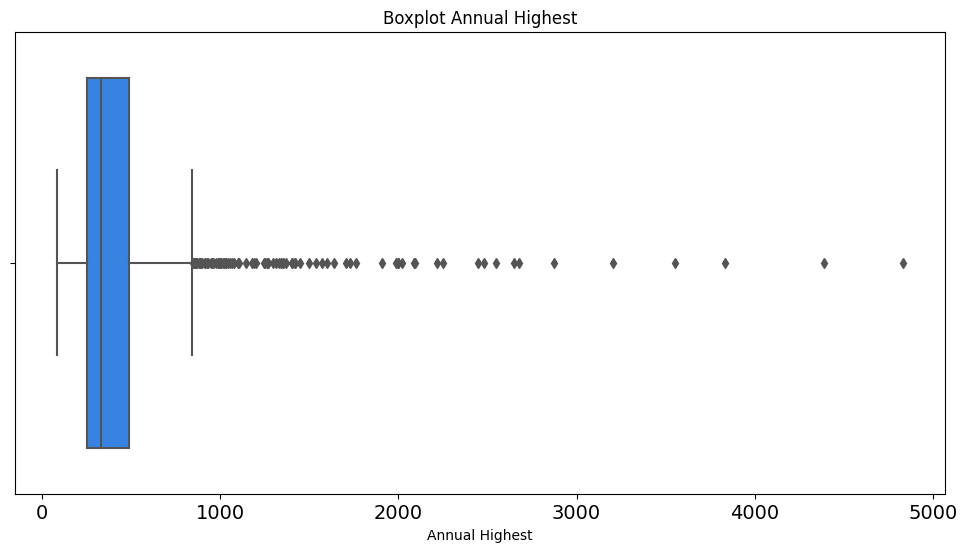

In [4]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = sns.boxplot(x = sneakers_data["Annual Highest"], color = (0.1, 0.5, 1.0))
plt.title("Boxplot Annual Highest")
plt.xlabel("Annual Highest")
plt.tick_params(labelsize = 14)
plt.show()

# Гістограма Annual Highest по Брендах

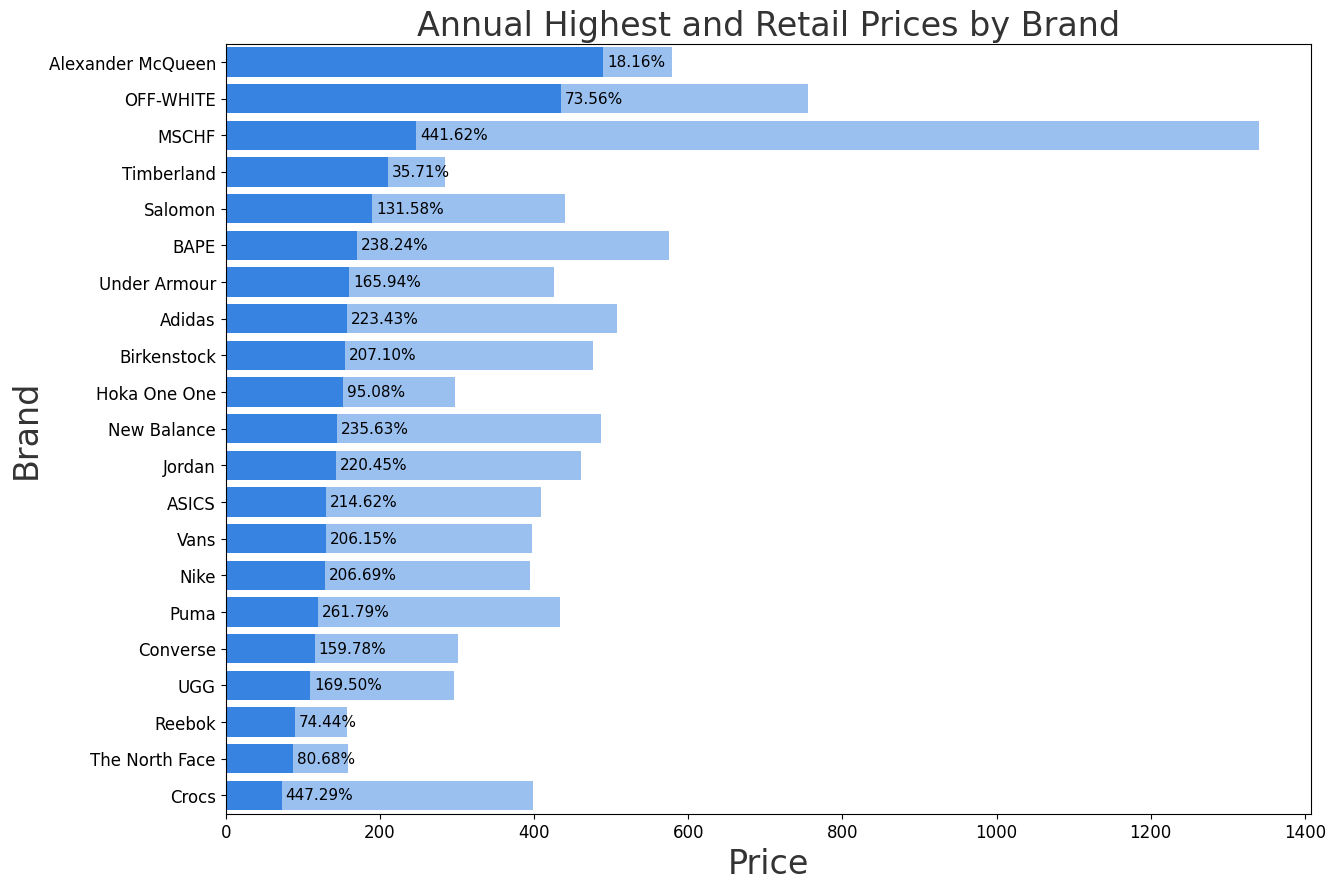

In [5]:
avg_deadstock_price_data = sneakers_data.groupby("Brand")["Annual Highest"].mean().reset_index()
avg_retail_price_data = sneakers_data.groupby("Brand")["Retail Price"].mean().reset_index()
merged = pd.merge(avg_deadstock_price_data, avg_retail_price_data, on = "Brand").sort_values(by = "Retail Price", ascending = False).reset_index(drop = True)
merged["Percentage Difference"] = ((merged["Annual Highest"] - merged["Retail Price"]) / merged["Retail Price"]) * 100

fig, ax = plt.subplots(figsize = (14, 10))
ax = sns.barplot(x = "Annual Highest", y = "Brand", data = merged, color = (0.1, 0.5, 1.0), alpha = 0.5)
ax = sns.barplot(x = "Retail Price", y = "Brand", data = merged, color = (0.1, 0.5, 1.0), alpha = 1.0)

for index, row in merged.iterrows():
    ax.text(row["Retail Price"] + 5, index, f"{row['Percentage Difference']:.2f}%", fontsize = 11, va = "center")

plt.title("Annual Highest and Retail Prices by Brand", fontsize = 24, alpha = 0.8)
plt.xlabel("Price", fontsize = 24, alpha = 0.8)
plt.ylabel("Brand", fontsize = 24, alpha = 0.8)
plt.tick_params(labelsize = 14)
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
plt.show()

# Кругова діаграма за загальними продажами

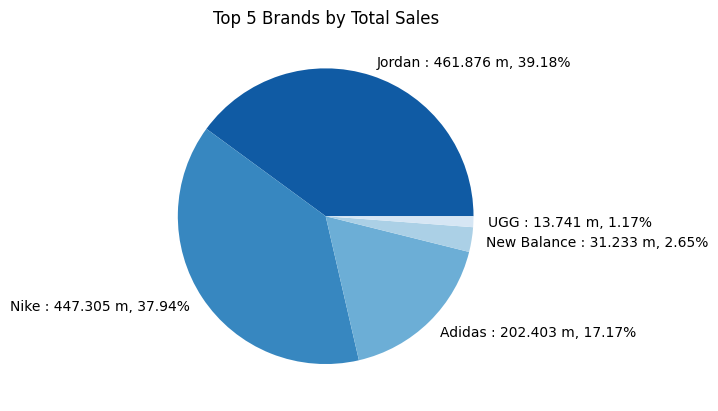

In [6]:
sneakers_data["Total Sales"] = sneakers_data["Average Deadstock Price"] * sneakers_data["Deadstock Sold"]
total_sales = sneakers_data["Total Sales"].sum()
brand_sales = sneakers_data.groupby("Brand")["Total Sales"].sum().reset_index()
top_5 = brand_sales.nlargest(5, columns = "Total Sales")

labels = [f"{brand} : {round(sales / 1_000_000, 3)} m, {round(sales / total_sales * 100, 2)}%" for brand, sales in zip(top_5["Brand"], top_5["Total Sales"])]
plt.pie(top_5["Total Sales"], labels = labels, colors = sns.color_palette("Blues_r", len(top_5)))
plt.title("Top 5 Brands by Total Sales")
plt.show()

# Кругова діаграма за кількістю проданих пар

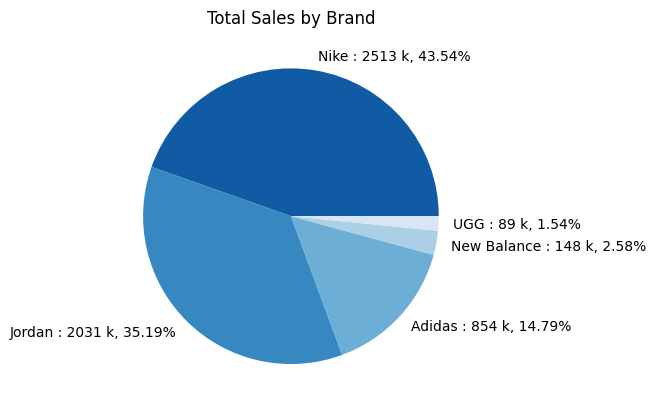

In [7]:
total_deadstock_sold_data = sneakers_data.groupby("Brand")["Deadstock Sold"].sum().reset_index()
total_deadstock_sold = total_deadstock_sold_data["Deadstock Sold"].sum()
top_5 = total_deadstock_sold_data.nlargest(5, columns = "Deadstock Sold")

labels = [f"{brand} : {(int)(sales / 1_000)} k, {round(sales / total_deadstock_sold * 100, 2)}%" for brand, sales in zip(top_5["Brand"], top_5["Deadstock Sold"])]
plt.pie(top_5["Deadstock Sold"], labels = labels, colors = sns.color_palette("Blues_r", len(top_5)))
plt.title("Total Sales by Brand")
plt.show()

# Підготовка даних до інтелектуального аналізу

In [8]:
x = sneakers_data.drop(columns = ["Sneaker Name", "Brand", "Release Date", "Change Percentage", "Volatility", "Sold This Year", "Annual Highest"], axis = 1)
y = sneakers_data["Annual Highest"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, train_size = 0.8, random_state = 0)
results = list()

# Допоміжні функції

In [9]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)

def build_scatter_plot(model, y: pd.DataFrame, x_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    plt.figure(figsize = (8, 8))
    plt.scatter(y_test, model.predict(x_test), color = (0.1, 0.5, 1.0), label = "Передбачені")
    plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw = 1)
    plt.scatter(y_test, y_test, color = (0.9, 0.1, 0.1), alpha = 0.65, label = "Справжні")
    plt.grid(linestyle = "--")
    plt.legend()
    plt.show()


def build_residual_plot(model, x_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
    predictions = model.predict(x_test)
    plt.figure(figsize = (8, 8))
    plt.scatter(predictions, y_test - predictions, color = (0.1, 0.5, 1.0), label = "Передбачені")
    plt.axhline(y = 0, color = "black", linestyle = "--", lw = 1)
    plt.scatter(predictions, [0] * len(predictions), color = (0.9, 0.1, 0.1), alpha = 0.65, label = "Справжні")
    plt.grid(linestyle = "--")
    plt.legend()
    plt.show()

# Linear Regression

Train score: 0.71706.
Test score: 0.64704.


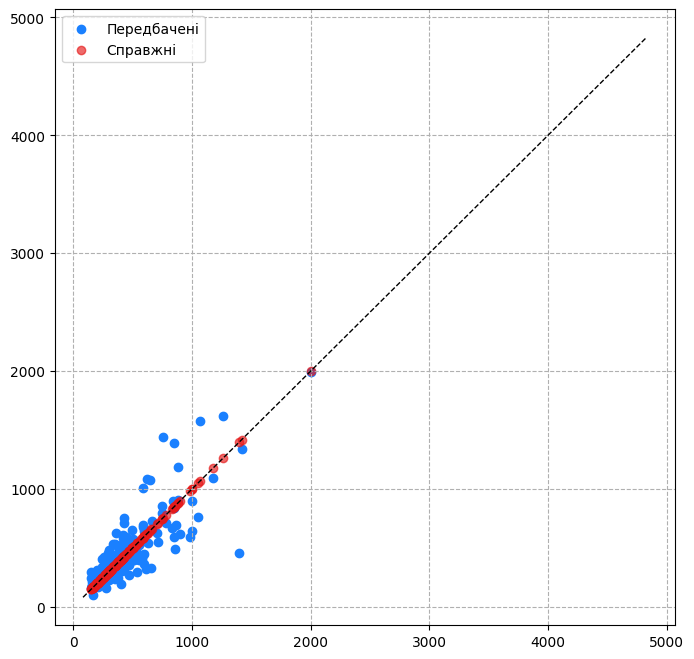

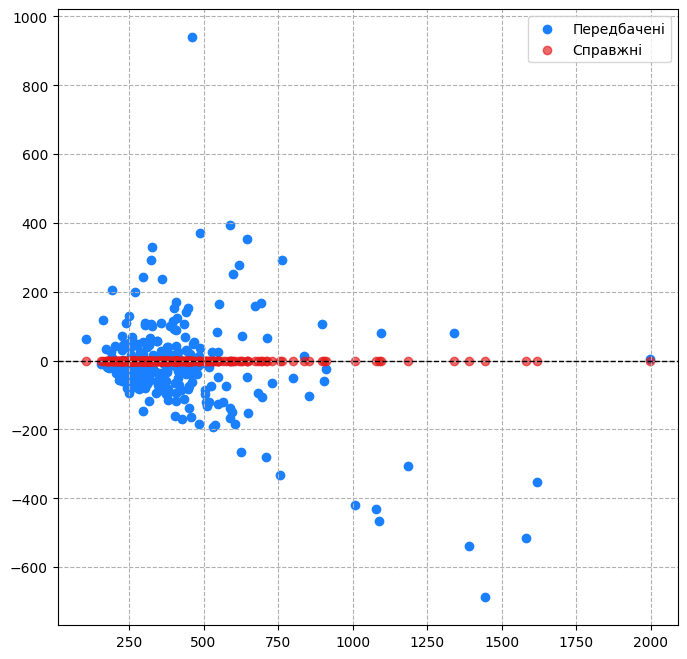

In [10]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

train_score = round(linear_model.score(x_train, y_train), 5)
test_score = round(linear_model.score(x_test, y_test), 5)
results.append({"Model": "Linear\nModel", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Linear\nModel", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_scatter_plot(linear_model, y, x_test, y_test)
build_residual_plot(linear_model, x_test, y_test)

# Lasso Regression

Train score: 0.71701.
Test score: 0.64944.


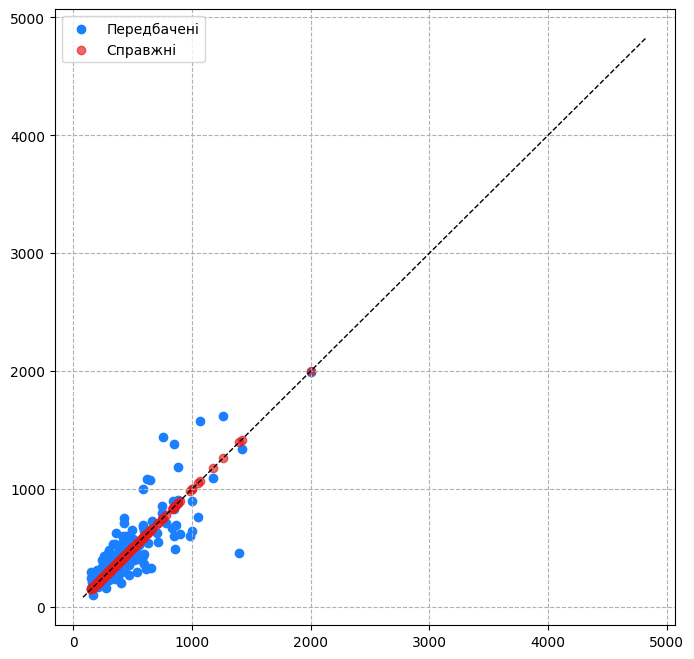

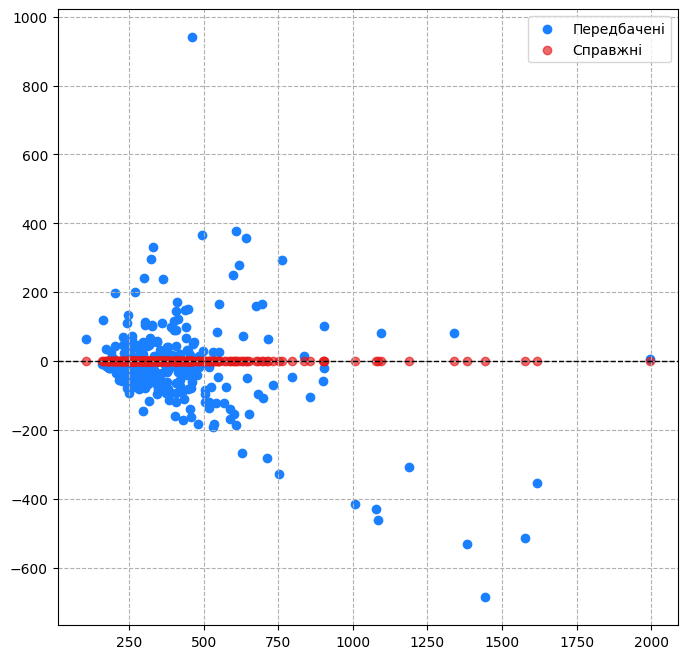

In [11]:
lasso_model = Lasso(random_state = 0, max_iter = 50000)
lasso_model = GridSearchCV(lasso_model, param_grid = {"alpha": [0.001, 0.005, 0.01, 0.05, 0.1, 1]}, cv = 5, verbose = 0 , n_jobs = 2)
lasso_model.fit(x_train, y_train)

lasso_model = Lasso(alpha = lasso_model.best_params_["alpha"], max_iter = 50000)
lasso_model.fit(x_train, y_train)

train_score = round(lasso_model.score(x_train, y_train), 5)
test_score = round(lasso_model.score(x_test, y_test), 5)
results.append({"Model": "Lasso\nModel", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Lasso\nModel", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_scatter_plot(lasso_model, y, x_test, y_test)
build_residual_plot(lasso_model, x_test, y_test)

# Random Forest Regressor

Train score: 0.95584.
Test score: 0.60693.


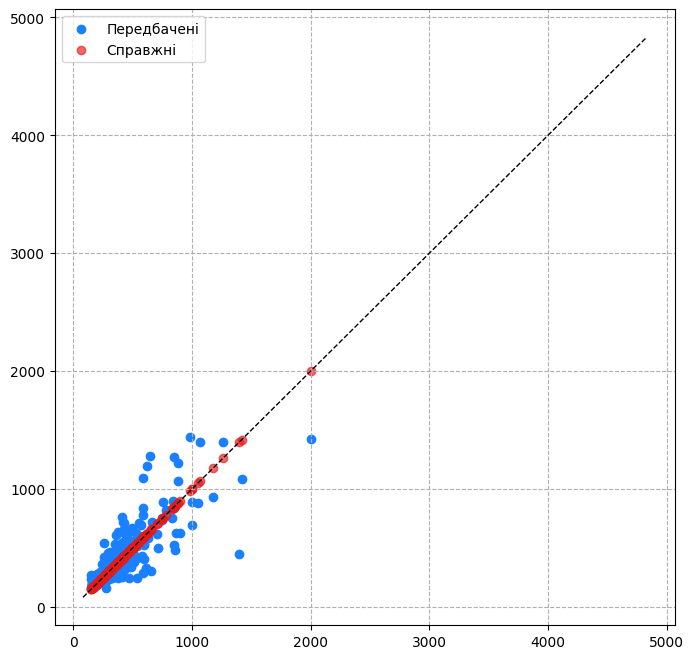

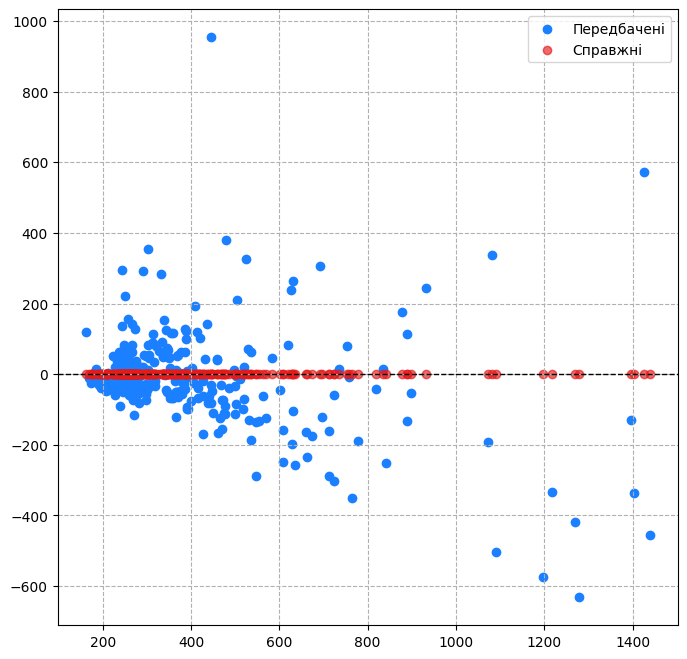

In [12]:
rf_model = RandomForestRegressor(random_state = 0, n_jobs = -2)
rf_model.fit(x_train, y_train)

train_score = round(rf_model.score(x_train, y_train), 5)
test_score = round(rf_model.score(x_test, y_test), 5)
results.append({"Model": "Random\nForest\nRegressor", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Random\nForest\nRegressor", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_scatter_plot(rf_model, y, x_test, y_test)
build_residual_plot(rf_model, x_test, y_test)

# Gradient Boosting Regressor

Train score: 0.9051.
Test score: 0.59103.


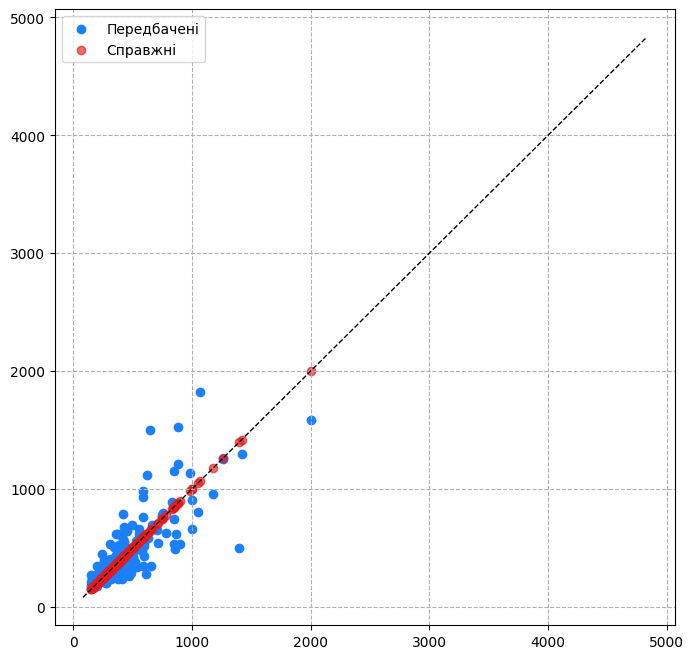

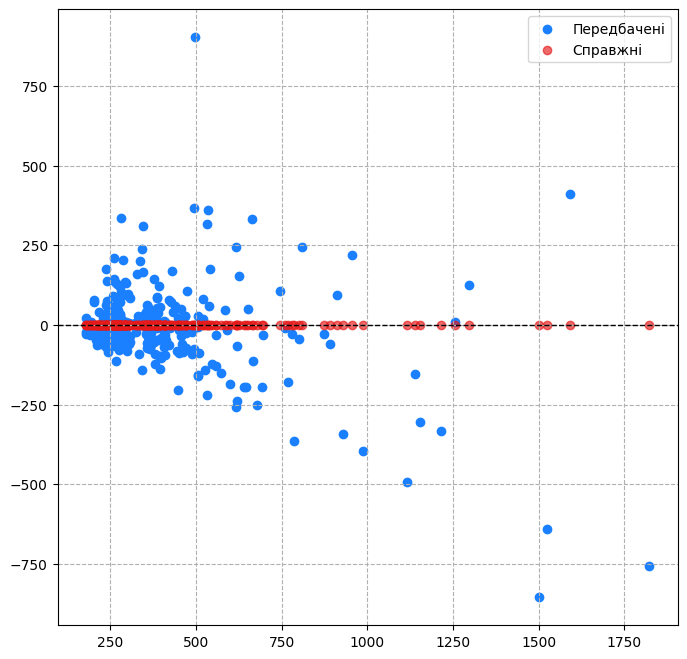

In [13]:
gb_model = GradientBoostingRegressor(random_state = 0)
gb_model.fit(x_train, y_train)

train_score = round(gb_model.score(x_train, y_train), 5)
test_score = round(gb_model.score(x_test, y_test), 5)
results.append({"Model": "Gradient\nBoosting\nRegressor", "R^2 Score": train_score, "Type": "Train"})
results.append({"Model": "Gradient\nBoosting\nRegressor", "R^2 Score": test_score, "Type": "Test"})
print(f"Train score: {train_score}.")
print(f"Test score: {test_score}.")

build_scatter_plot(gb_model, y, x_test, y_test)
build_residual_plot(gb_model, x_test, y_test)

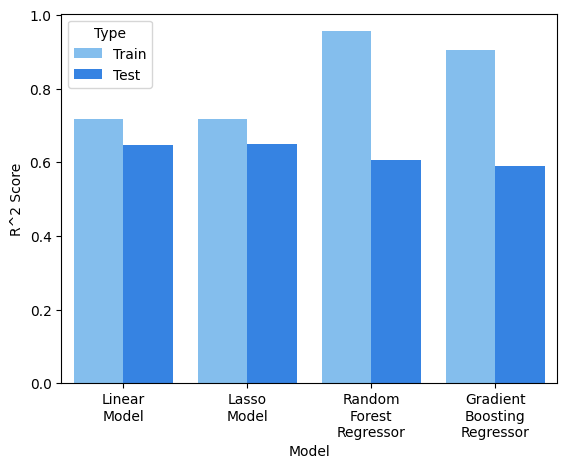

In [14]:
scores = pd.DataFrame(results, columns = ["Model", "R^2 Score", "Type"])
sns.barplot(x = "Model", y = "R^2 Score", hue = "Type", palette = [(0.45, 0.75, 1.0), (0.1, 0.5, 1.0)], data = scores)
plt.show()